<a href="https://colab.research.google.com/github/mohamedbakrey12/Advanced-Data-Science/blob/master/Copy_of_Custom_transfer_learning_CNN_lite_model_for_flowers_Using_way_1_Dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training on GPU will be fine for transfer learning as it is not a very demanding process.

## Imports

In [ ]:
import os, sys, math
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTOTUNE = tf.data.AUTOTUNE

Tensorflow version 2.15.0


## Configuration

In [ ]:
GCS_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec'
IMAGE_SIZE = [192, 192]

BATCH_SIZE = 64 # 128 works on GPU too but comes very close to the memory limit of the Colab GPU
EPOCHS = 40

VALIDATION_SPLIT = 0.19
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # do not change, maps to the labels in the data (folder names)

# gel list of flowers files and split data files between training and validation
filenames = tf.io.gfile.glob(GCS_PATTERN)
# get index at which data split begin
split = int(len(filenames) * VALIDATION_SPLIT)
# get list of training files ( from index 0 to index = split)
training_filenames = filenames[split:]
# get list of validation files ( from index = split to end of list )
validation_filenames = filenames[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))

#
validation_steps = int(3670 // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(3670 // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
With a batch size of 64, there will be 46 batches per training epoch and 10 batch(es) per validation run.


In [ ]:
#@title display utilities [RUN ME]

def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)

  for images, labels in dataset:
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    break;

  return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1

def display_9_images_from_dataset(dataset):
  subplot=331
  plt.figure(figsize=(13,13))
  images, labels = dataset_to_numpy_util(dataset, 9)
  for i, image in enumerate(images):
    title = CLASSES[labels[i]]
    subplot = display_one_flower(image, title, subplot)
    if i >= 8:
      break;

  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.argmax(predictions, axis=-1)
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;

  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    #plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

## Read images and labels from TFRecords

In [ ]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.io.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size will be needed for TPU
    class_label = example['class']
    return image, class_label

def load_dataset(filenames):
  # read from TFRecords. For optimal performance, read from multiple
  # TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.

  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
  return dataset

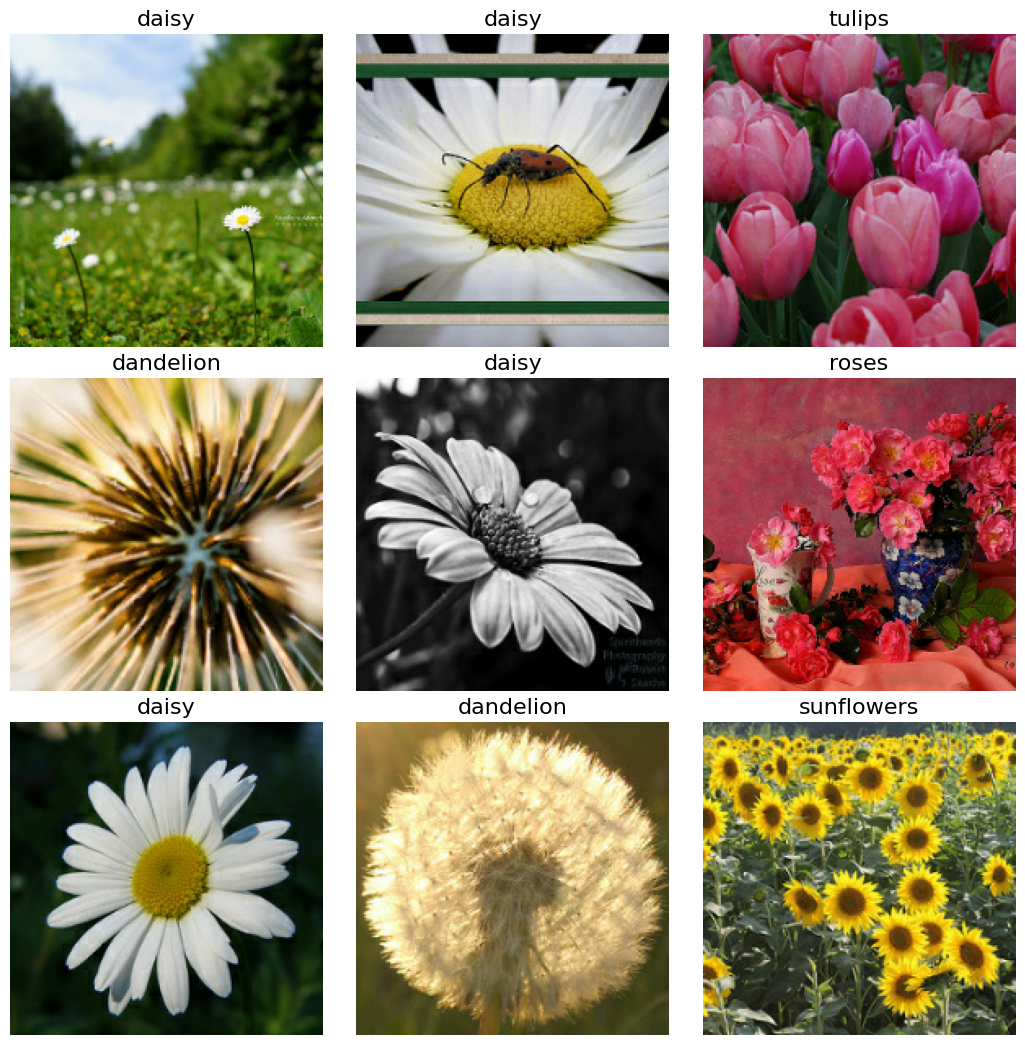

In [ ]:
display_9_images_from_dataset(load_dataset(training_filenames))

## training and validation datasets

In [ ]:
def get_batched_dataset(filenames, train=False):
  dataset = load_dataset(filenames)
  dataset = dataset.cache() # This dataset fits in RAM
  if train:
    # Best practices for Keras:
    # Training dataset: repeat then batch
    # Evaluation dataset: do not repeat
    dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTOTUNE) # prefetch next batch while training (autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  return dataset
  # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

# instantiate the datasets
training_dataset = get_batched_dataset(training_filenames, train=True)
validation_dataset = get_batched_dataset(validation_filenames, train=False)

In [ ]:
import os

import numpy as np

import tensorflow as tf
assert tf.__version__.startswith('2')

import matplotlib.pyplot as plt

image_path = tf.keras.utils.get_file(
      'flower_photos.tgz',
      'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
      extract=True)
image_path = os.path.join(os.path.dirname(image_path), 'flower_photos')

228813984/228813984 [==============================] - 1s 0us/step


In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
#pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


## Model [WORK REQUIRED HERE]

In [ ]:


### QUESTION 1.
#model = tf.keras.Sequential([
#    pretrained_model,
#    tf.keras.layers.Flatten(),
#    tf.keras.layers.Dense(5, activation='softmax')
#])

model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(input_shape=(192, 192)),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_192 (Func  (None, 6, 6, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 46080)             0         
                                                                 
 dense (Dense)               (None, 120)               5529720   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 20)                2420      
                                                                 
 dense_2 (Dense)             (None, 5)                 105       
                                                        

## Training

In [ ]:
history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=validation_steps)

Epoch 1/40
46/46 [==============================] - 14s 122ms/step - loss: 1.8879 - accuracy: 0.5445 - val_loss: 0.6416 - val_accuracy: 0.7688
Epoch 2/40
46/46 [==============================] - 4s 77ms/step - loss: 0.7124 - accuracy: 0.7520 - val_loss: 0.5142 - val_accuracy: 0.8250
Epoch 3/40
46/46 [==============================] - 4s 79ms/step - loss: 0.5484 - accuracy: 0.8003 - val_loss: 0.4801 - val_accuracy: 0.8391
Epoch 4/40
46/46 [==============================] - 4s 77ms/step - loss: 0.4696 - accuracy: 0.8353 - val_loss: 0.4534 - val_accuracy: 0.8562
Epoch 5/40
46/46 [==============================] - 4s 77ms/step - loss: 0.4165 - accuracy: 0.8522 - val_loss: 0.4670 - val_accuracy: 0.8453
Epoch 6/40
46/46 [==============================] - 4s 77ms/step - loss: 0.3696 - accuracy: 0.8590 - val_loss: 0.4329 - val_accuracy: 0.8641
Epoch 7/40
46/46 [==============================] - 4s 79ms/step - loss: 0.3266 - accuracy: 0.8736 - val_loss: 0.4856 - val_accuracy: 0.8406
Epoch 8/40


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


<ipython-input-5-a4859c1ed5bf>:57: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


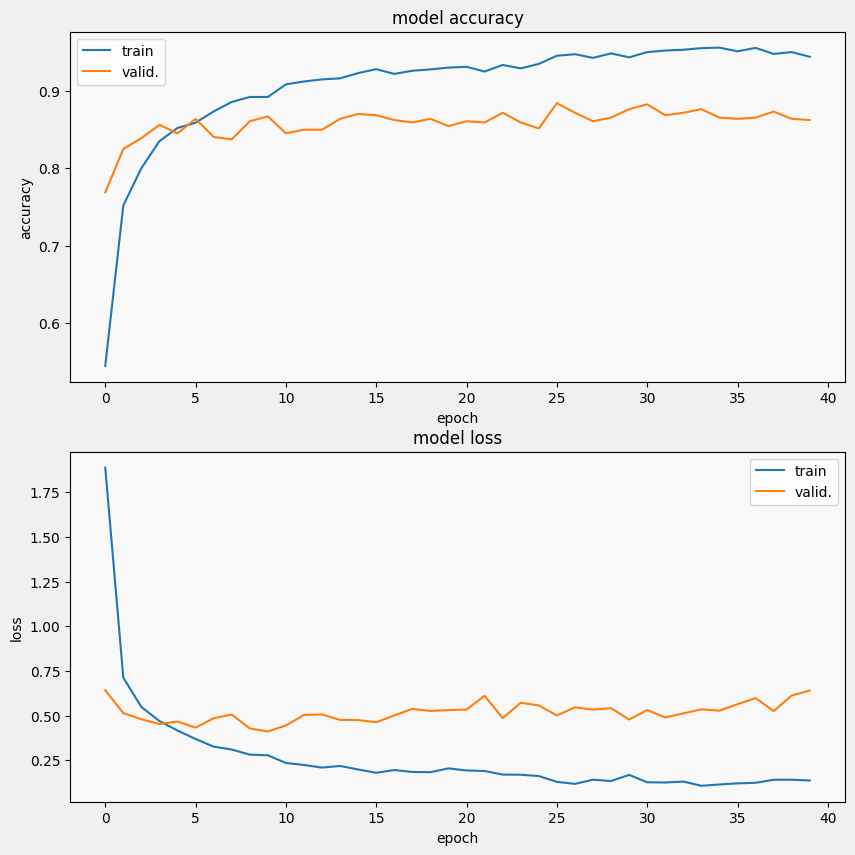

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

## Predictions

In [ ]:
# random input: execute multiple times to change results
flowers, labels = dataset_to_numpy_util(load_dataset(validation_filenames).skip(np.random.randint(300)), 9)

predictions = model.predict(flowers, steps=1)
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())

1/1 [==============================] - 2s 2s/step
['tulips', 'daisy', 'dandelion', 'dandelion', 'dandelion', 'roses', 'daisy', 'daisy', 'tulips']


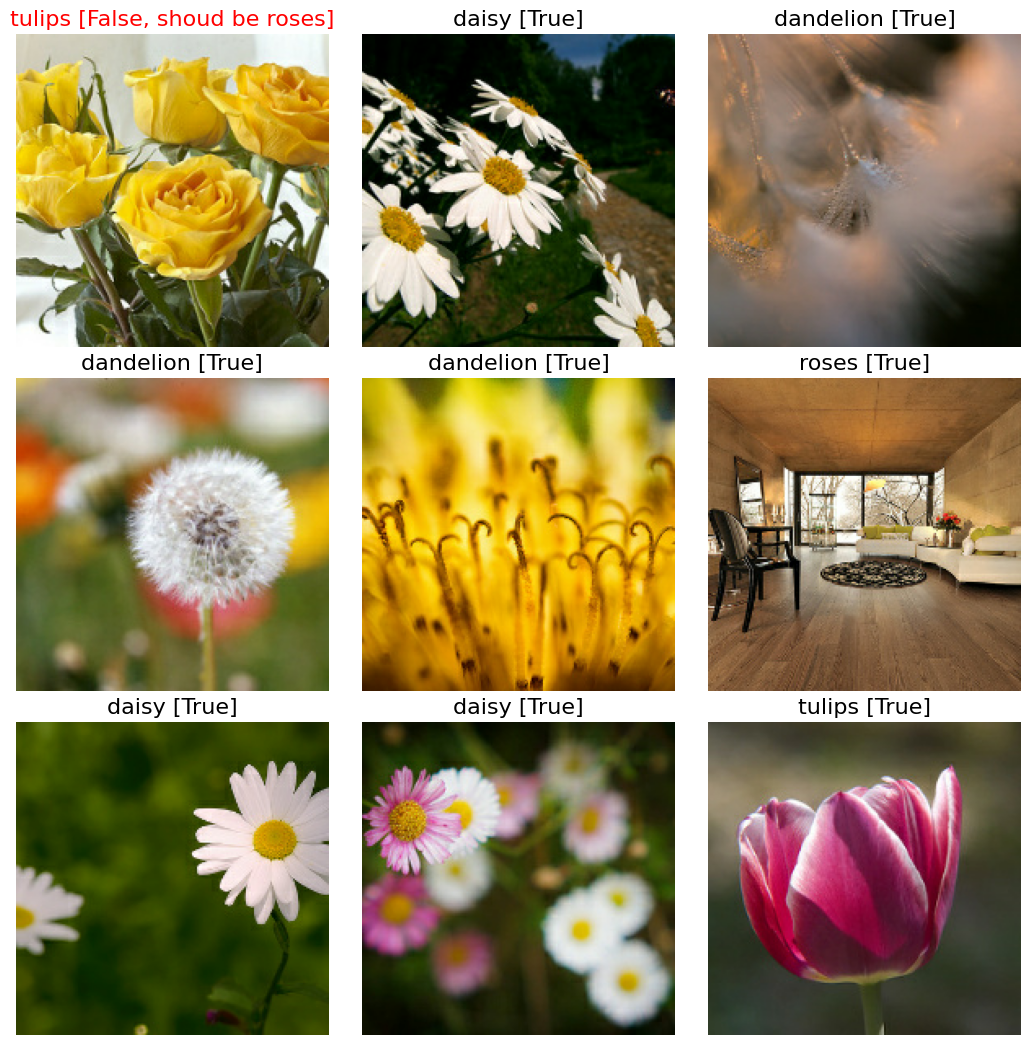

In [ ]:
display_9_images_with_predictions(flowers, predictions, labels)

## Convert the Keras model to TensorFlow Lite
Now as we have trained the digit classifer model, we will convert it to TensorFlow Lite format for mobile deployment.


In [ ]:
model.export("models")

# Convert Keras model to TF Lite format.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_float_model = converter.convert()

# Show model size in KBs.
float_model_size = len(tflite_float_model) / 1024
print('Float model size = %dKBs.' % float_model_size)

Saved artifact at 'models'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 192, 192, 3), dtype=tf.float32, name='mobilenetv2_1.00_192_input')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  136514196209008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136514193806384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136514193807616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136514193808848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136514193810080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136514196207248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136514193809376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136514193807264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136514193815184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136514193816416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1365141938

*As* we will deploy our model to a mobile device, we want our model to be as small and as fast as possible. **Quantization** is a common technique often used in on-device machine learning to shrink ML models. Here we will use 8-bit number to approximate our 32-bit weights, which in turn shrinks the model size by a factor of 4.

See [TensorFlow documentation](https://www.tensorflow.org/lite/performance/post_training_quantization) to learn more about other quantization techniques.

In [ ]:
# Re-convert the model to TF Lite using quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Show model size in KBs.
quantized_model_size = len(tflite_quantized_model) / 1024
print('Quantized model size = %dKBs,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / float_model_size))

Quantized model size = 7853KBs,
which is about 25% of the float model size.


## Evaluate the TensorFlow Lite model

By using quantization, we often traded off a bit of accuracy for the benefit of having a significantly smaller model. Let's calculate the accuracy drop of our quantized model.

## Download the TensorFlow Lite model

Let's get our model and integrate it into an Android app.

If you see an error when downloading mnist.tflite from Colab, try running this cell again.

In [ ]:
# Save the quantized model to file to the Downloads directory
f = open('flowers.tflite', "wb")
f.write(tflite_quantized_model)
f.close()

# Download the digit classification model
from google.colab import files
files.download('flowers.tflite')

print('`flowers.tflite` has been downloaded')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

`flowers.tflite` has been downloaded


## License



---


author: Martin Gorner<br>
twitter: @martin_gorner


---


Copyright 2021 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---


This is not an official Google product but sample code provided for an educational purpose
